In [11]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sympy import *
%matplotlib notebook
from numba import jit, njit
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [23]:
D = 0.5  # Коэффициент миграции
birthKoeff = 5.0  # Коэффициент рождения новых людей
deathKoeff = 1.  # Коэффициент смертность населения

NX = 100 #количество точек по оси OX
x0 = 0. # начало отрезка 
L = 100. # конец отрезка
h = (L - x0) / (NX - 1) # шаг по OX

KT = 1000 #количество точек по времени
t0 = 0. # начальный момент времени
T = 100 # конечный момент времени
tau = (T - t0) / (KT - 1) # шаг по времени

sigma = tau*D/h**2 #sigma - число Куранта

A = np.zeros((NX - 2, NX - 2))
d = np.zeros((NX - 2))
x = np.linspace(x0, L, NX)

In [24]:
def showAllConstant():
    print("Коэффициент миграции (D) = " + str(D) + '\t\tРождения новых людей (a) = ' + str(birthKoeff) +
          "\nСмертность населения (σ) = " + str(deathKoeff))
    print("Количество точек по ОХ (N) = " + str(NX) + "\t\tКоличество точек по времени (KT) = " + str(KT))
    print("число Куранта = " + str(sigma))

In [25]:
@njit
def getStartMatrix():  # Заполнение начальной матрицы нулями, и также обозначение начального рассспределения
    u = np.zeros((NX, KT), dtype=np.float64)
    for i in range(0, NX):
        u[i][0] = math.exp(-(i) ** 2)
    u[0][0] = 10
    return u

In [26]:
@njit
def thomasAlgorithm(A, d):  # Tridiagonal matrix algorithm . Или метод прогонки
    n = len(d)
    P = np.zeros(n - 1)
    Q = np.zeros(n - 1)
    x = np.zeros(n)
    P[0] = A[0][1] / -A[0][0]
    Q[0] = -d[0] / -A[0][0]
    for i in range(1, n - 1):  # находим прогоночные коэффициенты
        a = A[i][i - 1]
        b = A[i][i]
        c = A[i][i + 1]

        P[i] = c / (-b - a * P[i - 1])
        Q[i] = (a * Q[i - 1] - d[i]) / (-b - a * P[i - 1])
    x[-1] = (A[n - 1][n - 2] * Q[n - 2] - d[n - 1]) / (-A[n - 1][n - 1] - A[n - 1][n - 2] * P[n - 2])
    for i in range(n - 2, -1, -1):  # Находим неизвекстные
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [27]:
#@jit(nopython=True)
def createAndSolveMatrixOld(typeK): #заполняем трехдиагональную матрицу Ax=d
    u = getStartMatrix()
    #print(u)
    for i in range(1,KT): 
        A[0, 0] = - 2*sigma - (birthKoeff*tau*u[1][i - 1])/typeK(i, u[1][i-1]) - deathKoeff*tau - 1
        A[0, 1] = sigma
        d[0] = (birthKoeff*tau+1)*(-u[1][i - 1]) - sigma * u[0][i] 

        for j in range(1, NX-3):
            A[j, j - 1] = sigma
            A[j, j] = - 2*sigma - (birthKoeff*tau*u[j + 1][i - 1])/typeK(i, u[j][i - 1]) - deathKoeff*tau - 1
            A[j, j + 1] = sigma
            d[j] = (a*tau+1)*(-u[j + 1][i - 1])
    
        A[NX - 3, NX - 3] = - 2*sigma - (birthKoeff*tau*u[NX-2][i - 1])/typeK(i, u[NX-2][i - 1]) - deathKoeff*tau - 1
        A[NX - 3, NX - 4] = sigma
        d[NX - 3] = (birthKoeff*tau+1)*(-u[NX-2][i - 1]) - sigma *u[NX - 1][i] 
        #print (A,d)
        u[1:NX - 1, i] = thomasAlgorithm(A, d)
        #print(u)
    return u

In [28]:
#@jit(nopython=True)
def createAndSolveUImplicitMethods(typeK): #заполняем трехдиагональную матрицу Ax=d
    u = getStartMatrix()
    a = sigma
    b = lambda ukj: -2*sigma - (birthKoeff * tau * ukj)/typeK() -1 -tau*deathKoeff 
    c = sigma
    for k in range(1, KT):
        for j in range(0, NX-3):
            if j == 0:
                A[j][j] = b(u[j+1][k-1])
                A[j][j+1] = c
                d[j] = -(birthKoeff*tau+1)*u[j+1][k-1] - sigma * u[j][k-1]
            if j == NX - 3:
                A[j][j+1] = a
                A[j][j] = b(u[j][k-1])
                d[j] = -(birthKoeff*tau+1)*u[j][k-1] - sigma * u[j+1][k-1]
            else:
                A[j][j-1] = a
                A[j][j] = b(u[j][k-1])
                A[j][j+1] = c
                d[j] = -(birthKoeff*tau+1)*u[j][k-1]
        u[1:NX - 1, k] = thomasAlgorithm(A, d)
        #print(u)
    return u

In [29]:
@njit
def podQuad(u): # высчитывание интеграла как плошадь под криволинейной трапецей
    inter = 0
    for j in range(NX):
        inter = inter + u[j]
    inter *= h
    return inter

In [30]:
@njit
def createAndSolveUByExplicitMethods(carryingCapacityFunction): #Решение с помощью явной схемы
    u = getStartMatrix()
    u_0 = np.zeros((NX))
    #print('\tСистема устойчивая' if sigma <= 0.5 else '\tСистема не устойчива')
    for k in range(0, KT-1):
        for j in range(NX):
            ujk=u[j][k]
            if j == 0:
                u[j][k+1]=sigma*(u[j+1][k]-2*ujk)+tau*birthKoeff*ujk*(1-carryingCapacityFunction(ujk,k,u_0))-tau*deathKoeff*ujk+ujk
            if j == NX - 1:
                u[j][k+1]=sigma*(-2*ujk+u[j-1][k])+tau*birthKoeff*ujk*(1-carryingCapacityFunction(ujk,k,u_0))-tau*deathKoeff*ujk+ujk
            else:
                u[j][k+1]=sigma*(u[j+1][k]-2*ujk+u[j-1][k])+tau*birthKoeff*ujk*(1-carryingCapacityFunction(ujk,k,u_0))-tau*deathKoeff*ujk+ujk
            u_0 = u[0:NX, k]
    return u

$$F(u)=au^k_j\cdot(1-u^{k+1}_j/K)- \sigma u^{k+1}_j$$

In [31]:
@njit
def carryingCapacityFunction(ukj, k=0, u2=0): return ukj/17

showAllConstant()

u = createAndSolveUByExplicitMethods(carryingCapacityFunction)
#u = createAndSolveMatrixOld(typeK)
#u = createAndSolveUImplicitMethods(typeK)
u.max()

Коэффициент миграции (D) = 0.5		Рождения новых людей (a) = 5.0
Смертность населения (σ) = 1.0
Количество точек по ОХ (N) = 100		Количество точек по времени (KT) = 1000
число Куранта = 0.04905405405405405


13.6

<IPython.core.display.Javascript object>


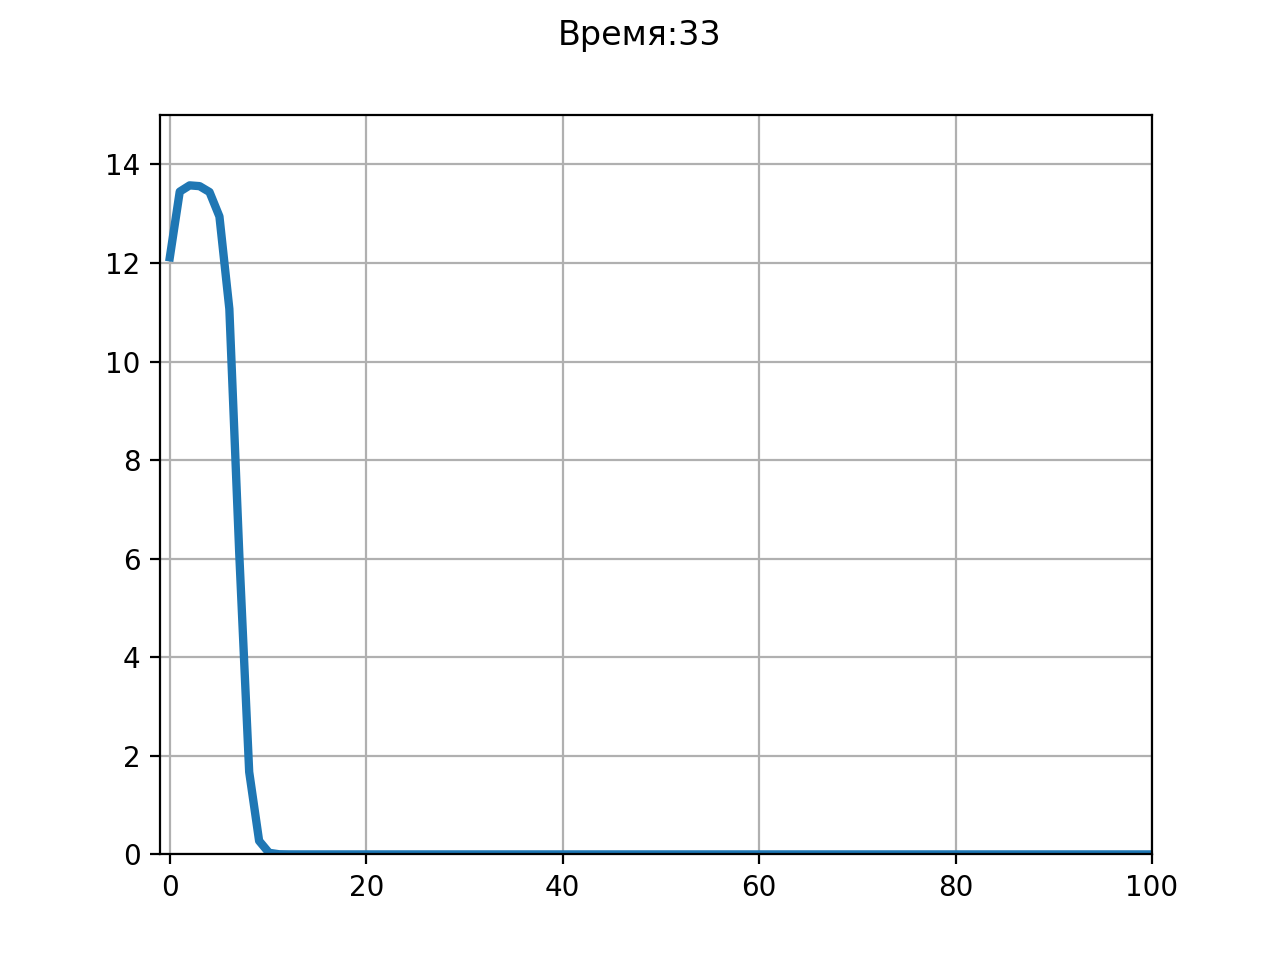

In [32]:
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 15) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

# plt.plot(x, u[:,0], label='t=0')
# plt.plot(x, u[:,10], label='t=10')
# plt.plot(x, u[:,100], label='t=100')
# plt.plot(x, u[:,200], label='t=200')
# plt.plot(x, u[:,500], label='t=500')
# plt.plot(x, u[:,900], label='t=900')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()


In [198]:
# Мы получили матрицу решений u(x, t), строки которой отвечают за x, а столбцы за момент времени t. 
# Чтобы найти скорость необходимо пройденное расстояние поделить на время. 
# То есть надо какую-то дельта x поделить на какую-то дельта t.
# Для этого выбираем любой u(xi, ti) (в коде u[int(N/3), int(K/3)) и пытаемся найти очень-очень близкий к нему, 
# почти равный u(xi, ti) по значению, но в другой момент времени не в int(K/3)
# (не для всех других моментов времени, а только для одного другого момента времени int(K/3) + 1!!), говорю почти равный,
# потому то решение построено на сетке и прям такого же значения может не оказаться. Как только нашли самое близкое из возможных
# пусть это будет u(xj, tj), то можно сразу найти скорость abs(xj - xi) / tau, tau - потому что мы взяли следующий момент времени
# а шаг равен tau, если бы взяли не int(K/3) + 1, а int(K/3) + 2, то делили бы на 2*tau
diff = 0.5 
value = 0
print(u[int(NX/3), int(KT/3)])
print()
for i in range(1, NX - 1):
    if (abs(u[int(NX/3), int(KT/3)] - u[i, int(KT/3) + 1]) < diff and x[int(NX/3)] != x[i]):
        print(abs(u[int(NX/3), int(KT/3)] - u[i, int(KT/3) + 1]))
        diff = abs(u[int(NX/3), int(KT/3)] - u[i, int(KT/3) + 1])
        value = abs(x[int(NX/3)] - x[i])
        
        print(value)
#print(int(NX/3))
print('Speed:', value/tau)

13.6

0.15336202526335185
332.3323323323324
0.015481677696685736
331.33133133133134
0.001561558585882139
330.33033033033036
0.00015749336255055368
329.32932932932937
1.5884098397478397e-05
328.3283283283284
1.602000004652382e-06
327.32732732732734
1.6157063065236343e-07
326.32632632632635
1.6295299332114155e-08
325.32532532532537
1.643472913315236e-09
324.3243243243244
1.6575363304127677e-10
323.32332332332334
1.6717294215595757e-11
322.32232232232235
1.6857626405908377e-12
321.32132132132136
1.7053025658242404e-13
320.3203203203204
1.7763568394002505e-14
319.31931931931933
1.7763568394002505e-15
318.31831831831835
0.0
317.31731731731736
Speed: 3172.8558558558566


In [45]:
@njit
def carryingCapacityFunction(ukj, k, u2=0): 
    denominator =  6000/(k+1)
    return ukj/denominator

showAllConstant()

u= createAndSolveUByExplicitMethods(carryingCapacityFunction)
u.max()

Коэффициент миграции (D) = 0.5		Рождения новых людей (a) = 5.0
Смертность населения (σ) = 1.0
Количество точек по ОХ (N) = 100		Количество точек по времени (KT) = 1000
число Куранта = 0.04905405405405405


242.58399644217786

<IPython.core.display.Javascript object>


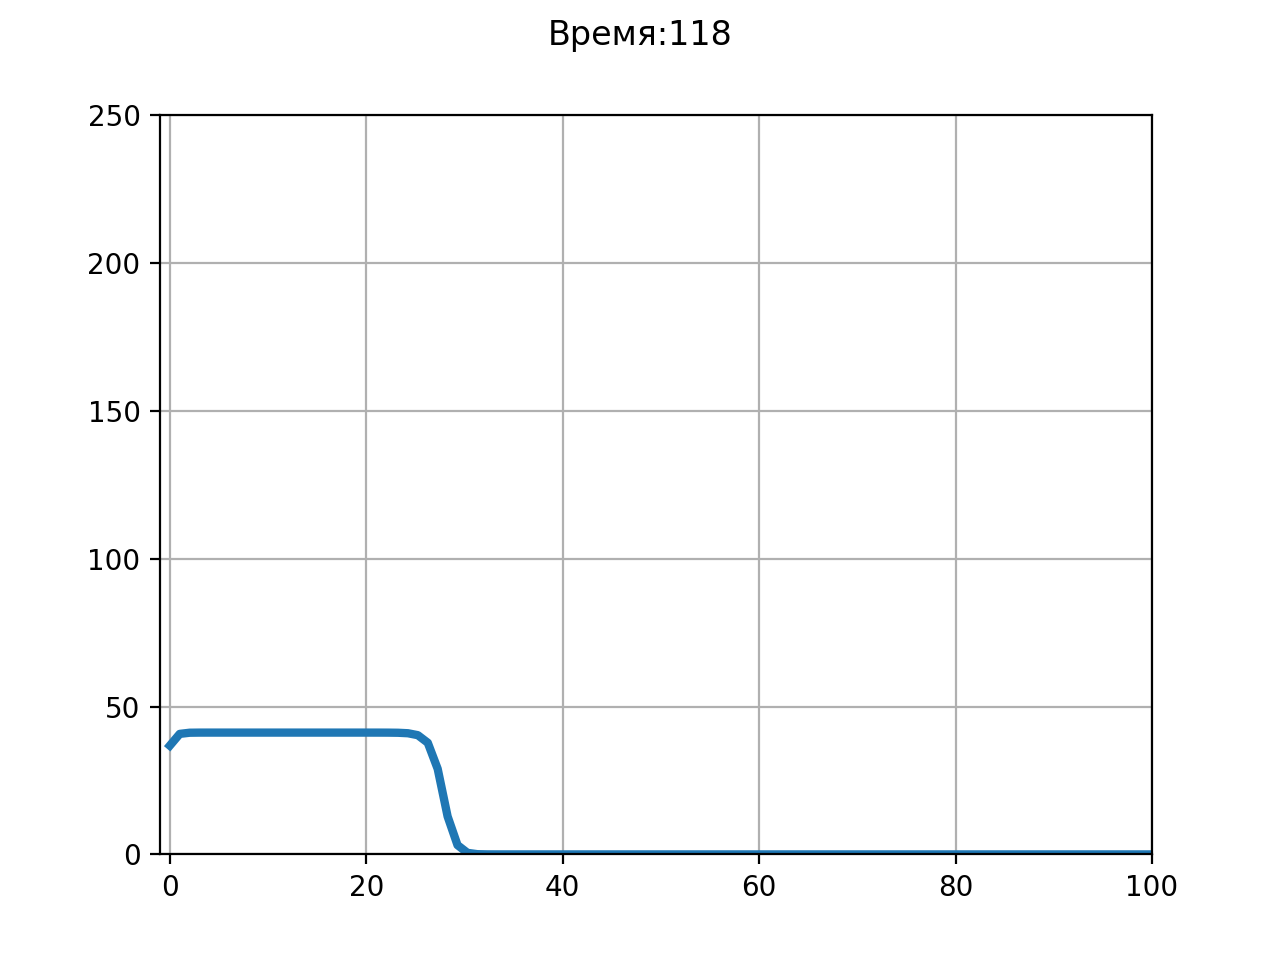

In [48]:
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 250) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

# plt.plot(x, u[:,0], label='t=0')
# plt.plot(x, u[:,10], label='t=10')
# plt.plot(x, u[:,50], label='t=50')
# plt.plot(x, u[:,70], label='t=70')
# plt.plot(x, u[:,100], label='t=100')
# plt.plot(x, u[:,200], label='t=200')
# plt.plot(x, u[:,500], label='t=500')
# plt.plot(x, u[:,900], label='t=900')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()


In [49]:
K0 = 12
K1 = .5

@njit
def carryingCapacityFunction(ukj, i, u_0): 
    integ_tmp = podQuad(u_0)
    K = K0 + K1*integ_tmp
    return ukj/K


u = createAndSolveUByExplicitMethods(carryingCapacityFunction)
u.max()

3.0788607383732183e+131

<IPython.core.display.Javascript object>


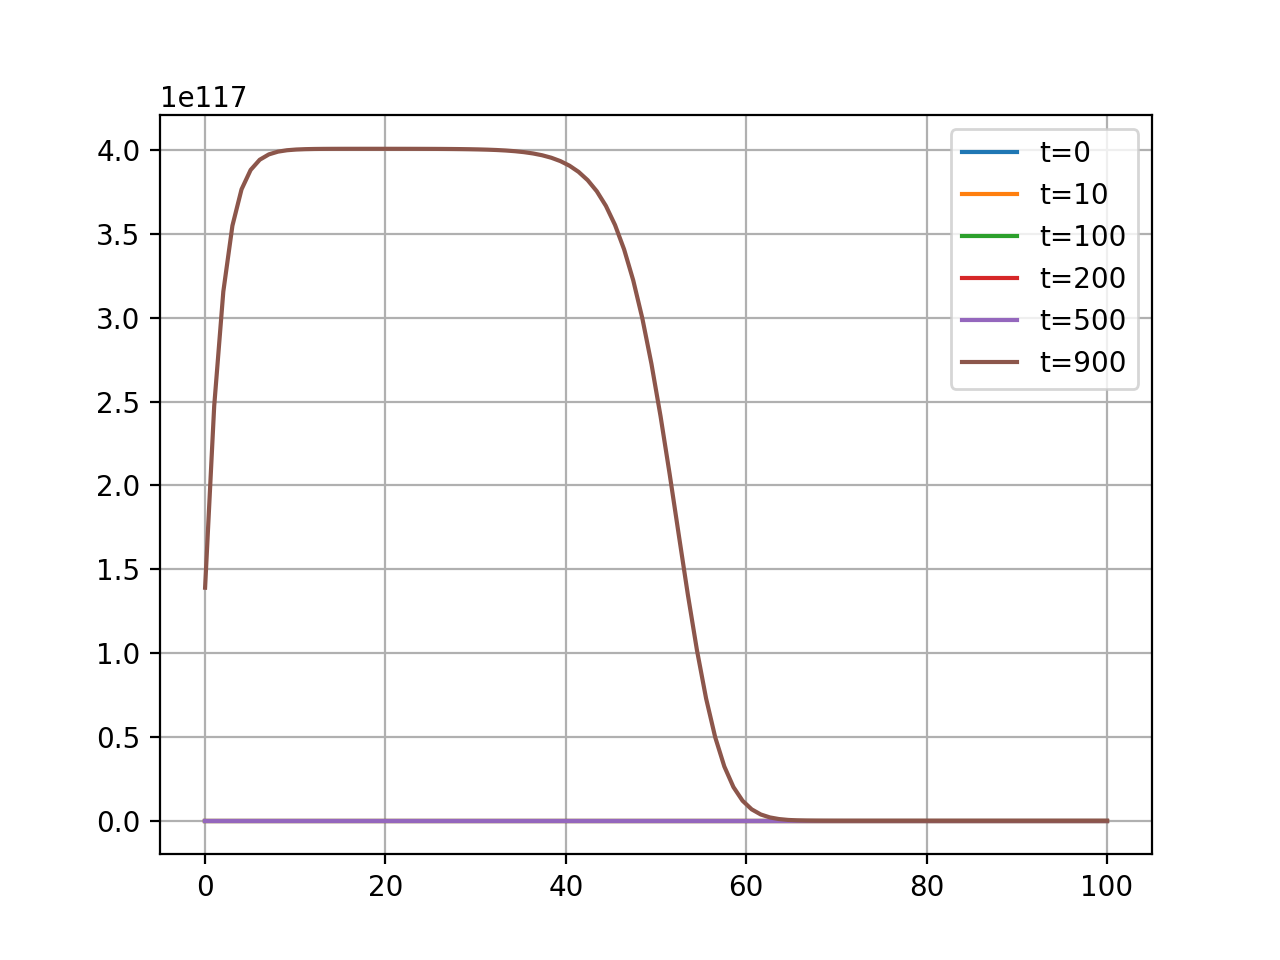

In [50]:
# fig = plt.figure(facecolor='white')
# ax = plt.axes(xlim=(-1, L), ylim=(0, 100) )
# line, = ax.plot([ ], [ ], lw=3)
# def redraw(i):
#     line.set_data(x, u[:,i])
#     string = 'Время:'+str(i)
#     plt.suptitle(string)
# anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
# plt.grid(True)
# plt.show()

plt.plot(x, u[:,0], label='t=0')
plt.plot(x, u[:,10], label='t=10')
plt.plot(x, u[:,100], label='t=100')
plt.plot(x, u[:,200], label='t=200')
plt.plot(x, u[:,500], label='t=500')
plt.plot(x, u[:,900], label='t=900')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [21]:
K0 = 12
K1 = .5


@njit
def carryingCapacityFunction(u1, i, u_0):
    integ_tmp = podQuad(u_0)
    K = K0 + K1*integ_tmp
    return integ_tmp/K

u = createAndSolveUByExplicitMethods(carryingCapacityFunction)
u.max()

nan

<IPython.core.display.Javascript object>


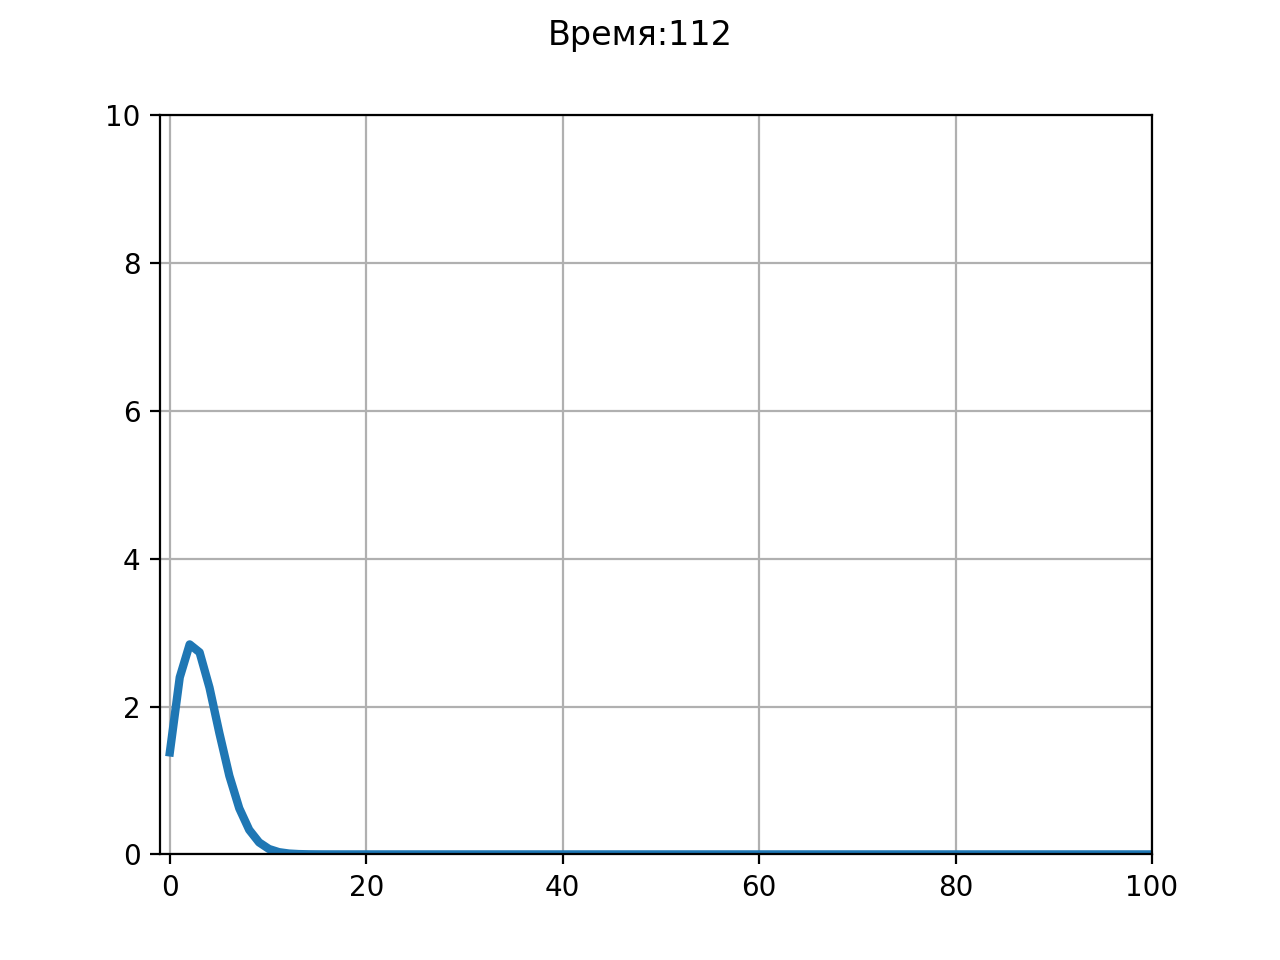

In [68]:
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 10) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

# plt.plot(np.linspace(0, L, NX), u[:,0], label='t=0')
# plt.plot(np.linspace(0, L, NX), u[:,10], label='t=10')
# plt.plot(np.linspace(0, L, NX), u[:,50], label='t=50')
# plt.plot(np.linspace(0, L, NX), u[:,100], label='t=100')
# plt.plot(np.linspace(0, L, NX), u[:,200], label='t=200')
# plt.plot(np.linspace(0, L, NX), u[:,500], label='t=500')
# plt.plot(np.linspace(0, L, NX), u[:,900], label='t=900')
# plt.legend(loc='best')
# plt.grid()
# plt.show()